# Editing Graph State

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!


In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Editing state 



Previously, we introduced breakpoints.

We used them to interrupt the graph and await user approval before executing the next node.

But breakpoints are also [opportunities to modify the graph state](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/).

Let's set up our agent with a breakpoint before the `assistant` node.

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

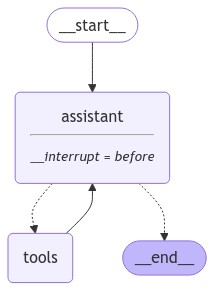

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [5]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='d64b1d67-8e8b-49b2-9b92-849d3a865711')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef744ca-9853-6bca-8000-aeee5bab08c6'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2024-09-16T16:56:48.219223+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef744ca-984f-6aac-bfff-60ee6633d6cf'}}, tasks=(PregelTask(id='dfe1befa-328c-c60f-41b6-80f19cc6b603', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

Now, we can directly apply a state update.

Remember, updates to the `messages` key will use the `add_messages` reducer:
 
* If we want to over-write the existing message, we can supply the message `id`.
* If we simply want to append to our list of messages, then we can pass a message without an `id` specified, as shown below.

In [6]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef744ca-9873-639e-8001-097f2e945103'}}

Let's have a look.

We called `update_state` with a new message. 

The `add_messages` reducer appends it to our state key, `messages`.

In [7]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed with our agent, simply by passing `None` and allowing it proceed from the current state.

We emit the current and then proceed to execute the remaining nodes.

In [8]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2WO0vEjHybtz8eQtO37o42N5)
 Call ID: call_2WO0vEjHybtz8eQtO37o42N5
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


Now, we're back at the `assistant`, which has our `breakpoint`.

We can again pass `None` to proceed.

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


## Editing graph state with LangGraph API



We can interact with our agent via the SDK.

![Screenshot 2024-08-26 at 9.59.19 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf2fbfb576f8e53ed930_edit-state-human-feedback1.png)

Let's get the URL for the local deployment from Studio.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [10]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:52210")

Our agent is defined in `assistant/agent.py`. 

If you look at the code, you'll see that it *does not* have a breakpoint! 
 
Of course, we can add it to `agent.py`, but one very nice feature of the API is that we can pass in a breakpoint!

Here, we pass a `interrupt_before=["assistant"]`.

In [11]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '2564fa8a-90c8-49ce-9917-cb6487f63772', 'example': False}
--------------------------------------------------


In [12]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '2564fa8a-90c8-49ce-9917-cb6487f63772',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '258e15d1-2bed-1cdc-cc52-4987a697c2c5',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef744ca-aa1b-6d23-b57c-a1f032c76261',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '91dfda7c-ea31-4dfc-8b7c-017013975aa7',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-16T16:56:50.126970+00:00',
 'checkpoint_id': '1ef744ca-aa85-6525-8000-1fab56735d0e',
 'parent_checkpoint_id': '1ef744ca-aa77-6a7b-bfff-cc960341bdfa'}

We can look at the last message in state.

In [13]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '2564fa8a-90c8-49ce-9917-cb6487f63772',
 'example': False}

We can edit it!

In [14]:
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '2564fa8a-90c8-49ce-9917-cb6487f63772',
 'example': False}

Remember, as we said before, updates to the `messages` key will use the same `add_messages` reducer. 

If we want to over-write the existing message, then we can supply the message `id`.

Here, we did that. We only modified the message `content`, as shown above.

In [15]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'configurable': {'thread_id': '91dfda7c-ea31-4dfc-8b7c-017013975aa7',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef744ca-ab60-63dc-8001-99e064b8b339'},
 'checkpoint_id': '1ef744ca-ab60-63dc-8001-99e064b8b339'}

Now, we resume by passing `None`. 

In [16]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '2564fa8a-90c8-49ce-9917-cb6487f63772', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_PPhVzsAdKPUNUN0V7VaMaQIK', 'function': {'arguments': '{"a":3,"b":6}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857'}, 'type': 'ai', 'name': None, 'id': 'run-3908e058-3376-4007-873d-a99de94805a1', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 6}, 'id': 'call_PPhVzsAdKPUNUN0V7VaMaQIK', 

In [17]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '18', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '14519d3e-f666-462e-a84b-c0bf2f3b00ab', 'tool_call_id': 'call_PPhVzsAdKPUNUN0V7VaMaQIK', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 and 3! (which is 6) is 18.', 'additional_kwargs': {}, 'response_metadata': {'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857'}, 'type': 'ai', 'name': None, 'id': 'run-f125a751-2834-4c9c-a28e-4ff0cb4b2066', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------------------------------------


## Awaiting user input


So, it's clear that we can edit our agent state after a breakpoint.

Now, what if we want to allow for human feedback to perform this state update?

We'll add a node that [serves as a placeholder for human feedback](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup) within our agent.

This `human_feedback` node allow the user to add feedback directly to state.
 
We specify the breakpoint using `interrupt_before` our `human_feedback` node.

We set up a checkpointer to save the state of the graph up until this node.

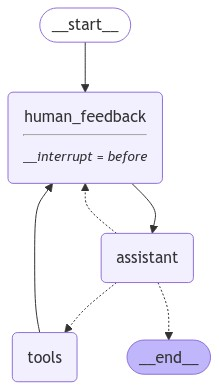

In [18]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_GFhFSnxixe0uXtntoSdX9W2d)
 Call ID: call_GFhFSnxixe0uXtntoSdX9W2d
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


We will get feedback from the user.

We use `.update_state` to update the state of the graph with the human response we get, as before.

We use the `as_node="human_feedback"` parameter to apply this state update as the specified node, `human_feedback`.

In [20]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


## Dynamic Breakpoint

Breakpoints are set by the developer on a specific node during graph compilation. 

But, sometimes it is helpful to allow the graph **dynamically interrupt** itself!

This is an internal breakpoint, and [can be achieved using `NodeInterrupt`](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/dynamic_breakpoints/#run-the-graph-with-dynamic-interrupt).

This has a few specific benefits: 

(1) you can do it conditionally (from inside a node based on developer-defined logic).

(2) you can communicate to the user why its interrupted (by passing whatever you want to the `NodeInterrupt`).

Let's create a graph where a `NodeInterrupt` is thrown based upon length of the input.

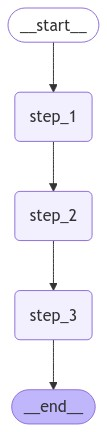

In [21]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# input has more than 5 characters
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}


If we inspect the graph state at this point, we the node set to execute next (`step_2`).


In [23]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


In [24]:
print(state.tasks)

(PregelTask(id='76b8f89c-9b7e-37bd-62a9-8e0654e52e3c', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', when='during'),), state=None),)


We can try to resume the graph from the breakpoint. 

But, this just re-runs the same node! 

Unless state is changed we will be stuck here.

In [25]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}


In [26]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


In [27]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef744e6-0396-6c5a-8002-dda6a8844972'}}

In [28]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


### Using the LangGraph API

In [31]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:52370"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [32]:
thread = await client.threads.create()
input_dict = {"input": "hello world"}

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=input_dict,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef744ee-4879-62a6-8cda-e927a09f8be4'}



Receiving new event of type: values...
{'input': 'hello world'}



Receiving new event of type: values...
{'input': 'hello world'}





In [33]:
current_state = await client.threads.get_state(thread['thread_id'])

In [34]:
current_state['next']

['step_2']

In [35]:
await client.threads.update_state(thread['thread_id'], {"input": "hi!"})

{'configurable': {'thread_id': '215eb837-2d64-465e-85bc-2461fbbcd4af',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef744f0-7e46-63bb-8002-047caf3df5d9'},
 'checkpoint_id': '1ef744f0-7e46-63bb-8002-047caf3df5d9'}

In [36]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="dynamic_breakpoints",
    input=None,
    stream_mode="values",):
    
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef744f0-c914-69ef-aaef-85cb5f59938f'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}



Receiving new event of type: values...
{'input': 'hi!'}





In [37]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'input': 'hi!'},
 'next': [],
 'tasks': [],
 'metadata': {'step': 4,
  'run_id': '1ef744f0-c914-69ef-aaef-85cb5f59938f',
  'source': 'loop',
  'writes': {'step_3': {'input': 'hi!'}},
  'parents': {},
  'user_id': '',
  'graph_id': 'dynamic_breakpoints',
  'thread_id': '215eb837-2d64-465e-85bc-2461fbbcd4af',
  'created_by': 'system',
  'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c'},
 'created_at': '2024-09-16T17:13:53.447970+00:00',
 'checkpoint_id': '1ef744f0-c9ab-69a4-8004-a33e04817f0e',
 'parent_checkpoint_id': '1ef744f0-c99f-67ad-8003-650b6a20ecd1'}